### Moive Recommendation Using PySpark DataFrame and RDD in Databricks
In this notebook, we will use an Alternating Least Squares (ALS) algorithm with Spark 'MLlib' APIs to predict the ratings for the movies in [MovieLens small dataset](https://grouplens.org/datasets/movielens/latest/)

In [2]:
# Load libraries
from pyspark.sql import SparkSession
from pyspark.sql.functions import col
from pyspark.sql.functions import col, udf
from pyspark.sql.types import ArrayType, StringType
from pyspark.sql.functions import explode
import pyspark.sql.functions as f

import numpy as np
import pandas as pd
from pyspark.mllib.recommendation import ALS, Rating #this is different from the pyspark.ml.recommendation library
import math
#from pyspark import SparkConf
from pyspark.context import SparkContext
import time
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.learning_curve import learning_curve
import matplotlib.pyplot as plt
import seaborn as sns

import os
os.environ["PYSPARK_PYTHON"] = "python3"

## Part1: Data ETL and Data Exploration

In [4]:
spark = SparkSession \
    .builder \
    .appName("moive analysis") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()

In [5]:
movies = spark.read.load("/FileStore/tables/movies.csv", format='csv', header = True)
ratings = spark.read.load("/FileStore/tables/ratings.csv", format='csv', header = True)
links = spark.read.load("/FileStore/tables/links.csv", format='csv', header = True)
tags = spark.read.load("/FileStore/tables/tags.csv", format='csv', header = True)

In [6]:
display(movies.take(5))

movieId,title,genres
1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
2,Jumanji (1995),Adventure|Children|Fantasy
3,Grumpier Old Men (1995),Comedy|Romance
4,Waiting to Exhale (1995),Comedy|Drama|Romance
5,Father of the Bride Part II (1995),Comedy


In [7]:
display(ratings.take(5)) 

userId,movieId,rating,timestamp
1,1,4.0,964982703
1,3,4.0,964981247
1,6,4.0,964982224
1,47,5.0,964983815
1,50,5.0,964982931


In [8]:
display(links.take(5)) 

movieId,imdbId,tmdbId
1,0114709,862
2,0113497,8844
3,0113228,15602
4,0114885,31357
5,0113041,11862


In [9]:
display(tags.take(5)) 

userId,movieId,tag,timestamp
2,60756,funny,1445714994
2,60756,Highly quotable,1445714996
2,60756,will ferrell,1445714992
2,89774,Boxing story,1445715207
2,89774,MMA,1445715200


In [10]:
movies.printSchema()
ratings.printSchema()
links.printSchema()
tags.printSchema()

root
-- movieId: string (nullable = true)
-- title: string (nullable = true)
-- genres: string (nullable = true)

root
-- userId: string (nullable = true)
-- movieId: string (nullable = true)
-- rating: string (nullable = true)
-- timestamp: string (nullable = true)

root
-- movieId: string (nullable = true)
-- imdbId: string (nullable = true)
-- tmdbId: string (nullable = true)

root
-- userId: string (nullable = true)
-- movieId: string (nullable = true)
-- tag: string (nullable = true)
-- timestamp: string (nullable = true)

In [11]:
tmp1 = ratings.groupBy("userID").count().toPandas()['count'].min()
tmp2 = ratings.groupBy("movieId").count().toPandas()['count'].min()
print('For the users that rated movies and the movies that were rated:')
print('Minimum number of ratings per user is {}.'.format(tmp1))
print('Minimum number of ratings per movie is {}.'.format(tmp2))

For the users that rated movies and the movies that were rated:
Minimum number of ratings per user is 20.
Minimum number of ratings per movie is 1.

In [12]:
tmp1 = sum(ratings.groupBy("movieId").count().toPandas()['count'] == 1)
tmp2 = ratings.select('movieId').distinct().count()
print('{} out of {} movies are rated by only one user.'.format(tmp1, tmp2))

3446 out of 9724 movies are rated by only one user.

## Part 1: Spark SQL and OLAP

### Q1: The number of Users

In [15]:
num_of_users = ratings.select("userID").distinct().count()
print("The number of users is {}.".format(num_of_users))

The number of users is 610.

### Q2: The number of Movies

In [17]:
num_of_movies = movies.select("movieID").distinct().count()
print("The number of movies is {}.".format(num_of_movies))

The number of movies is 9742.

### Q3:  How many movies are rated by users? List movies not rated before

In [19]:
ratings = ratings.dropna(subset=["rating"])
num_of_rated_movies = ratings.select("movieID").distinct().count()
print("There are {} movies that have been rated by users.".format(num_of_rated_movies))

There are 9724 movies that have been rated by users.

In [20]:
tmp = movies.join(ratings.where(col("rating").isNull()), "movieID")
not_rated = tmp.select("title")
not_rated.show(5)

+-----+
title|
+-----+
+-----+

### Q4: List Movie Genres

In [22]:
@udf(ArrayType(StringType()))
def splitUdf(x):
    splitted = x.split('|')
    return [i for i in splitted]

dfv = movies.withColumn('genres', splitUdf(col('genres'))) \
     .select(col('movieID'), col('title'), col('genres'))
dfv.show(5)

+-------+--------------------+--------------------+
movieID| title| genres|
+-------+--------------------+--------------------+
 1| Toy Story (1995)|[Adventure, Anima...|
 2| Jumanji (1995)|[Adventure, Child...|
 3|Grumpier Old Men ...| [Comedy, Romance]|
 4|Waiting to Exhale...|[Comedy, Drama, R...|
 5|Father of the Bri...| [Comedy]|
+-------+--------------------+--------------------+
only showing top 5 rows

In [23]:
df_genre = dfv.withColumn("genres", explode("genres"))
distinct_df_genre = df_genre.select("genres").distinct()
distinct_df_genre.show(20)

+------------------+
 genres|
+------------------+
 Crime|
 Romance|
 Thriller|
 Adventure|
 Drama|
 War|
 Documentary|
 Fantasy|
 Mystery|
 Musical|
 Animation|
 Film-Noir|
(no genres listed)|
 IMAX|
 Horror|
 Western|
 Comedy|
 Children|
 Action|
 Sci-Fi|
+------------------+

In [24]:
genre_count = distinct_df_genre.count()
print("The total number of genres is {}.".format(genre_count))

The total number of genres is 20.

### Q5: Movie for Each Category

In [26]:
#df_genre.filter(df_genre.genres != "(no genres listed)").show()

In [27]:
df_genre = df_genre.groupby("genres").agg(f.concat_ws(", ", f.collect_list(df_genre.title)))
display(df_genre.take(1))

genres concat_ws(, , collect_list(title)) Crime Heat (1995), Casino (1995), Money Train (1995), Get Shorty (1995), Copycat (1995), Assassins (1995), Shanghai Triad (Yao a yao yao dao waipo qiao) (1995), Dead Man Walking (1995), Dead Presidents (1995), Usual Suspects, The (1995), Don't Be a Menace to South Central While Drinking Your Juice in the Hood (1996), Crossing Guard, The (1995), Things to Do in Denver When You're Dead (1995), Hate (Haine, La) (1995), Bottle Rocket (1996), Taxi Driver (1976), Rumble in the Bronx (Hont faan kui) (1995), Young Poisoner's Handbook, The (1995), Bad Boys (1995), Amateur (1994), Batman Forever (1995), Clockers (1995), Devil in a Blue Dress (1995), Die Hard: With a Vengeance (1995), Doom Generation, The (1995), Hackers (1995), Judge Dredd (1995), Net, The (1995), Strange Days (1995), Bushwhacked (1995), Heavenly Creatures (1994), Kiss of Death (1995), New Jersey Drive (1995), New York Cop (Nyû Yôku no koppu) (1993), Natural Born Killers (1994), Once Were Warriors (1994), Léon: The Professional (a.k.a. The Professional) (Léon) (1994), Pulp Fiction (1994), Shawshank Redemption, The (1994), Tales from the Hood (1995), Clear and Present Danger (1994), Crow, The (1994), Mask, The (1994), Bad Company (1995), Faster Pussycat! Kill! Kill! (1965), Jason's Lyric (1994), Above the Rim (1994), Beverly Hills Cop III (1994), Carlito's Way (1993), Fresh (1994), Getaway, The (1994), Hard Target (1993), Jimmy Hollywood (1994), Judgment Night (1993), Killing Zoe (1994), Menace II Society (1993), Perfect World, A (1993), RoboCop 3 (1993), Romeo Is Bleeding (1993), Serial Mom (1994), Striking Distance (1993), True Romance (1993), Escort, The (Scorta, La) (1993), Batman (1989), Silence of the Lambs, The (1991), Love and a .45 (1994), Fargo (1996), Primal Fear (1996), Courage Under Fire (1996), Substitute, The (1996), Mulholland Falls (1996), Heaven's Prisoners (1996), Striptease (1996), Trainspotting (1996), American Buffalo (1996), Ransom (1996), Godfather, The (1972), Supercop (Police Story 3: Supercop) (Jing cha gu shi III: Chao ji jing cha) (1992), Bound (1996), Carpool (1996), Kansas City (1996), Nothing to Lose (1994), Supercop 2 (Project S) (Chao ji ji hua) (1993), Bulletproof (1996), Some Like It Hot (1959), Charade (1963), To Catch a Thief (1955), Laura (1944), Thin Man, The (1934), Beat the Devil (1953), Last Man Standing (1996), Set It Off (1996), 2 Days in the Valley (1996), Freeway (1996), Die Hard (1988), Normal Life (1996), Crossfire (1947), Fish Called Wanda, A (1988), Bonnie and Clyde (1967), Dial M for Murder (1954), Reservoir Dogs (1992), Basic Instinct (1992), Funeral, The (1996), Return of the Pink Panther, The (1975), Wallace & Gromit: The Wrong Trousers (1993), Grifters, The (1990), Tie Me Up! Tie Me Down! (¡Átame!) (1990), Clockwork Orange, A (1971), Goodfellas (1990), Killer, The (Die xue shuang xiong) (1989), Psycho (1960), Godfather: Part II, The (1974), Once Upon a Time in America (1984), Sting, The (1973), Miller's Crossing (1990), Touch of Evil (1958), Femme Nikita, La (Nikita) (1990), Chinatown (1974), M (1931), Manchurian Candidate, The (1962), Fried Green Tomatoes (1991), Big Sleep, The (1946), Cape Fear (1962), Blood and Wine (Blood & Wine) (1996), Albino Alligator (1996), Batman Returns (1992), Sneakers (1992), Beavis and Butt-Head Do America (1996), La Cérémonie (1995), Hamlet (1996), Thieves (Voleurs, Les) (1996), Murder at 1600 (1997), Metro (1997), Gridlock'd (1997), Lost Highway (1997), Donnie Brasco (1997), Best Men (1997), Grosse Pointe Blank (1997), Face/Off (1997), Cop Land (1997), Desperate Measures (1998), Hoodlum (1997), L.A. Confidential (1997), Kiss the Girls (1997), U Turn (1997), Playing God (1997), Switchback (1997), Gang Related (1997), Deceiver (1997), Incognito (1997), Red Corner (1997), Man Who Knew Too Little, The (1997), Midnight in the Garden of Good and Evil (1997), Jackie Brown (1997), Big Lebowski, The (1998), Hard Rain (1998), Fallen (1998), Replacement

## Part2: Spark ALS based approach for training model
We will use an RDD-based API from [pyspark.mllib](https://spark.apache.org/docs/2.1.1/mllib-collaborative-filtering.html) to predict the ratings, so let's reload "ratings.csv" using ``sc.textFile`` and then convert it to the form of (user, item, rating) tuples.

### Please refer to Spark ML ALS model
https://databricks-prod-cloudfront.cloud.databricks.com/public/4027ec902e239c93eaaa8714f173bcfc/4999972933037924/899848065201823/8135547933712821/latest.html

In [29]:
#sc = SparkContext.getOrCreate(SparkConf().setMaster("local[*]"))
movie_rating = sc.textFile("/FileStore/tables/ratings.csv")

In [30]:
header = movie_rating.take(1)[0]
#convert to tuples
rating_data = movie_rating.filter(lambda line: line!=header).map(lambda line: line.split(",")).map(lambda tokens: (tokens[0],tokens[1],tokens[2])).cache()

In [31]:
# check three rows
rating_data.take(3)

Out[ 35 ]: [('1', '1', '4.0'), ('1', '3', '4.0'), ('1', '6', '4.0')]

Now we split the data into training/validation/testing sets using a 6/2/2 ratio.

In [33]:
training_RDD, validation_RDD, test_RDD = rating_data.randomSplit([6, 2, 2], seed = 774)

Prepare userID and movieID columns for the use of making predictions.

In [35]:
validation_for_predict_RDD = validation_RDD.map(lambda x: (x[0], x[1]))
test_for_predict_RDD = test_RDD.map(lambda x: (x[0], x[1]))

In [36]:
training_RDD.cache()

Out[ 38 ]: PythonRDD[12170] at RDD at PythonRDD.scala:56

In [37]:
validation_RDD.cache()

Out[ 39 ]: PythonRDD[12171] at RDD at PythonRDD.scala:56

In [38]:
test_RDD.cache()

Out[ 40 ]: PythonRDD[12172] at RDD at PythonRDD.scala:56

### ALS Model Selection and Evaluation

With the ALS model, we can use a grid search to find the optimal hyperparameters.

In [40]:
def train_ALS(train_data, validation_data, num_iters, reg_param, ranks):
    min_error = float('inf')
    best_rank = -1
    best_regularization = 0
    best_model = None
    for rank in ranks:
        for reg in reg_params:
            #train ALS model using pyspark.mllib.recommendation - RDD-based API
            model = ALS.train(training_RDD, rank, seed = 774, iterations = num_iters,
                              lambda_ = reg)
            #make predictions
            predictions = model.predictAll(validation_for_predict_RDD).map(lambda r: ((r[0], r[1]), r[2]))
            #get the rating result
            rates_and_preds = validation_RDD.map(lambda r: ((int(r[0]), int(r[1])), float(r[2]))).join(predictions)
            #get the RMSE /(error) of cross validation data
            cv_error = math.sqrt(rates_and_preds.map(lambda r: (r[1][0] - r[1][1])**2).mean())
            print ('{} latent factors and regularization = {}: validation RMSE is {:.4f}'.format(rank, reg, cv_error)) 
            if cv_error < min_error:
                min_error = cv_error
                best_rank = rank
                best_regularization = reg
                best_model = model
    print ('\n\nThe best model was trained with {} which has {} latent factors. \nRegularization parameter = {}'.format(best_rank, best_rank, best_regularization))
    return best_model

In [41]:
num_iterations = 10   #How many times will be iterate over the data
ranks = [6, 8, 10, 12, 14]   #Creates a list of latent factors, experiement with each
reg_params = [0.05, 0.1, 0.2, 0.4, 0.8]   #Test with regularization parameter

start_time = time.time()
final_model = train_ALS(training_RDD, validation_for_predict_RDD, num_iterations, reg_params, ranks)

print ('Total Runtime: {:.2f} seconds'.format(time.time() - start_time))

6 latent factors and regularization = 0.05: validation RMSE is 0.9737
6 latent factors and regularization = 0.1: validation RMSE is 0.9093
6 latent factors and regularization = 0.2: validation RMSE is 0.8907
6 latent factors and regularization = 0.4: validation RMSE is 0.9580
6 latent factors and regularization = 0.8: validation RMSE is 1.1749
8 latent factors and regularization = 0.05: validation RMSE is 0.9801
8 latent factors and regularization = 0.1: validation RMSE is 0.9055
8 latent factors and regularization = 0.2: validation RMSE is 0.8867
8 latent factors and regularization = 0.4: validation RMSE is 0.9572
8 latent factors and regularization = 0.8: validation RMSE is 1.1749
10 latent factors and regularization = 0.05: validation RMSE is 0.9928
10 latent factors and regularization = 0.1: validation RMSE is 0.9105
10 latent factors and regularization = 0.2: validation RMSE is 0.8884
10 latent factors and regularization = 0.4: validation RMSE is 0.9575
10 latent factors and regularization = 0.8: validation RMSE is 1.1749
12 latent factors and regularization = 0.05: validation RMSE is 1.0016
12 latent factors and regularization = 0.1: validation RMSE is 0.9114
12 latent factors and regularization = 0.2: validation RMSE is 0.8880
12 latent factors and regularization = 0.4: validation RMSE is 0.9567
12 latent factors and regularization = 0.8: validation RMSE is 1.1749
14 latent factors and regularization = 0.05: validation RMSE is 0.9913
14 latent factors and regularization = 0.1: validation RMSE is 0.9059
14 latent factors and regularization = 0.2: validation RMSE is 0.8887
14 latent factors and regularization = 0.4: validation RMSE is 0.9575
14 latent factors and regularization = 0.8: validation RMSE is 1.1749


The best model was trained with 8 which has 8 latent factors. 
Regularization parameter = 0.2
Total Runtime: 160.20 seconds

In [42]:
rating_data_for_predict_RDD = rating_data.map(lambda x: (x[0], x[1]))
predictions = final_model.predictAll(rating_data_for_predict_RDD).map(lambda r: ((r[0], r[1]), r[2]))
rates_and_preds = rating_data.map(lambda r: ((int(r[0]), int(r[1])), float(r[2]))).join(predictions)
#get X: features
X = rates_and_preds.map(lambda r: (r[0][0], r[0][1], r[1][0]))  
 #get y: target
y = rates_and_preds.map(lambda r: r[1][1])  

In [43]:
X_arr = np.reshape(np.array(X.collect()), (-1, 3))
X_arr.shape

Out[ 44 ]: (98801, 3)

In [44]:
X_df = pd.DataFrame(X_arr, columns = ["userID", "movieID", "rating"])
#X_df = X_df.dropna()
display(X_df.head(10))

userID,movieID,rating
489.0,2657.0,4.0
381.0,34319.0,4.0
480.0,440.0,2.5
274.0,1196.0,4.5
437.0,47.0,4.0
139.0,5349.0,3.0
474.0,1408.0,4.0
517.0,955.0,1.0
19.0,2491.0,4.0
152.0,48516.0,3.5


In [45]:
y_arr = np.reshape(np.array(y.collect()), (-1, 1))
y_arr.shape

Out[ 46 ]: (98801, 1)

In [46]:
y_df =  pd.DataFrame(y_arr, columns = ["predicted_rating"])
display(y_df.head(10))

predicted_rating
2.9532235753959615
3.4317660522452282
3.037620144122963
3.764698536077821
3.8986114144264166
2.0924074521235374
3.426848727750403
2.2002563587783737
2.0306762545073545
4.093962686778486


In [47]:
X = X_df[["userID", "movieID", "rating"]] #features we train
y = y_df[["predicted_rating"]] #target
cv = 5 #k-fold cross validation
iter_array = [1, 100, 500, 1000] #train_sizes

In [48]:
def plot_learning_curve():
  lg = LinearRegression()
  lg.fit(X, y) #fit
  train_sizes, train_scores, validation_scores = learning_curve( \
                                                                estimator = lg, \
                                                                X = X, \
                                                                y = y, \
                                                                cv = cv, \
                                                                scoring = 'neg_mean_squared_error', \
                                                                train_sizes = iter_array \
                                                               )
    
  #calculate mean and std deviation for training and cross validation data
  train_scores_mean = -np.mean(train_scores, axis=1) #use the minus sign to offset negative mean squared error
  train_scores_std = np.std(train_scores, axis=1)
  validation_scores_mean = -np.mean(validation_scores, axis=1) 
  validation_scores_std = np.std(validation_scores, axis=1)
  
  #plot learning curve
  plt.clf() #clear the old figure before plotting a new one
  plt.figure() #create figure object
  plt.style.use('seaborn-whitegrid')
  plt.title('Learning Curves for a Linear Regression Model', fontsize = 18)
  plt.xlabel('Training set size', fontsize = 14)
  plt.ylabel('MSE', fontsize = 14)
  
  #plot the std deviation as a transparent range at each training set size
  plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
  plt.fill_between(train_sizes, validation_scores_mean - validation_scores_std, validation_scores_mean + validation_scores_std, alpha=0.1, color="g")
    
  plt.plot(train_sizes, train_scores_mean, color = "r", label = "Training error")
  plt.plot(train_sizes, validation_scores_mean, color = "g", label = "Cross-validation error")
  plt.legend(labelspacing=0.5, bbox_to_anchor=(1.00, 0.98), fontsize = 12)

  plt.ylim(0, 0.6)
  plt.show()

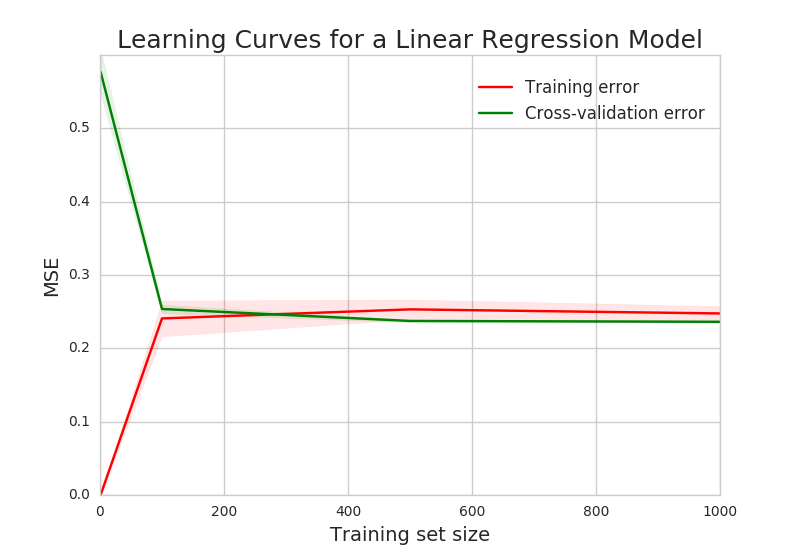

In [49]:
display(plot_learning_curve())

In [50]:
lg = LinearRegression()
lg.fit(X, y) #fit
train_sizes, train_scores, validation_scores = learning_curve( \
                                                                estimator = lg, \
                                                                X = X, \
                                                                y = y, \
                                                                cv = cv, \
                                                                scoring = 'neg_mean_squared_error', \
                                                                train_sizes = iter_array \
                                                               )
    
#calculate mean and std deviation for training and cross validation data
train_scores_mean = -np.mean(train_scores, axis=1) #use the minus sign to offset negative mean squared error
train_scores_std = np.std(train_scores, axis=1)
validation_scores_mean = -np.mean(validation_scores, axis=1) 
validation_scores_std = np.std(validation_scores, axis=1)

In [51]:
print('Training scores:\n\n', train_scores)
print('\n', '-' * 70) # separator to make the output easy to read
print('\nValidation scores:\n\n', validation_scores)

Training scores:

 [[-0. -0. -0. -0. -0. ]
 [-0.28961938 -0.22855194 -0.22855194 -0.22855194 -0.22855194]
 [-0.22627635 -0.25985383 -0.25985383 -0.25985383 -0.25985383]
 [-0.22746697 -0.25258297 -0.25258297 -0.25258297 -0.25258297]]

 ----------------------------------------------------------------------

Validation scores:

 [[-0.51639002 -0.58706429 -0.59843412 -0.5863109 -0.59572571]
 [-0.24202696 -0.25601901 -0.25882776 -0.2567636 -0.25460086]
 [-0.23908378 -0.23598546 -0.23963043 -0.23609847 -0.23589209]
 [-0.23602105 -0.23529662 -0.23897102 -0.23532463 -0.23534793]]

In [52]:
print('Mean training scores\n\n', pd.Series(train_scores_mean, index = train_sizes))
print('\n', '-' * 20) 
print('\nStd deviation training scores\n\n', pd.Series(train_scores_std, index = train_sizes))

Mean training scores

 1 -0.000000
100 0.240765
500 0.253138
1000 0.247560
dtype: float64

 --------------------

Std deviation training scores

 1 0.000000
100 0.024427
500 0.013431
1000 0.010046
dtype: float64

In [53]:
print('\nMean validation scores\n\n',pd.Series(validation_scores_mean, index = train_sizes))
print('\n', '-' * 20) 
print('\nStd deviation validation scores\n\n',pd.Series(validation_scores_std, index = train_sizes))

Mean validation scores

 1 0.576785
100 0.253648
500 0.237338
1000 0.236192
dtype: float64

 --------------------

Std deviation validation scores

 1 0.030566
100 0.005969
500 0.001659
1000 0.001416
dtype: float64

In [54]:
def plot_learning_curve_DecisionTree():
  dt = DecisionTreeRegressor()
  dt.fit(X, y) #fit
  train_sizes, train_scores, validation_scores = learning_curve( \
                                                                estimator = dt, \
                                                                X = X, \
                                                                y = y, \
                                                                cv = cv, \
                                                                scoring = 'neg_mean_squared_error', \
                                                                train_sizes = iter_array \
                                                               )
    
  #calculate mean and std deviation for training and cross validation data
  train_scores_mean = -np.mean(train_scores, axis=1) #use the minus sign to offset negative mean squared error
  train_scores_std = np.std(train_scores, axis=1)
  validation_scores_mean = -np.mean(validation_scores, axis=1) 
  validation_scores_std = np.std(validation_scores, axis=1)
  
  #plot learning curve
  plt.clf() #clear the old figure before plotting a new one
  plt.figure() #create figure object
  plt.style.use('seaborn-whitegrid')
  plt.title('Learning Curves for a Linear Regression Model', fontsize = 18)
  plt.xlabel('Training set size', fontsize = 14)
  plt.ylabel('MSE', fontsize = 14)
  
  #plot the std deviation as a transparent range at each training set size
  plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
  plt.fill_between(train_sizes, validation_scores_mean - validation_scores_std, validation_scores_mean + validation_scores_std, alpha=0.1, color="g")
    
  plt.plot(train_sizes, train_scores_mean, color = "r", label = "Training error")
  plt.plot(train_sizes, validation_scores_mean, color = "g", label = "Cross-validation error")
  plt.legend(labelspacing=0.5, bbox_to_anchor=(1.00, 0.98), fontsize = 12)

  plt.ylim(-0.1, 1)
  plt.show()

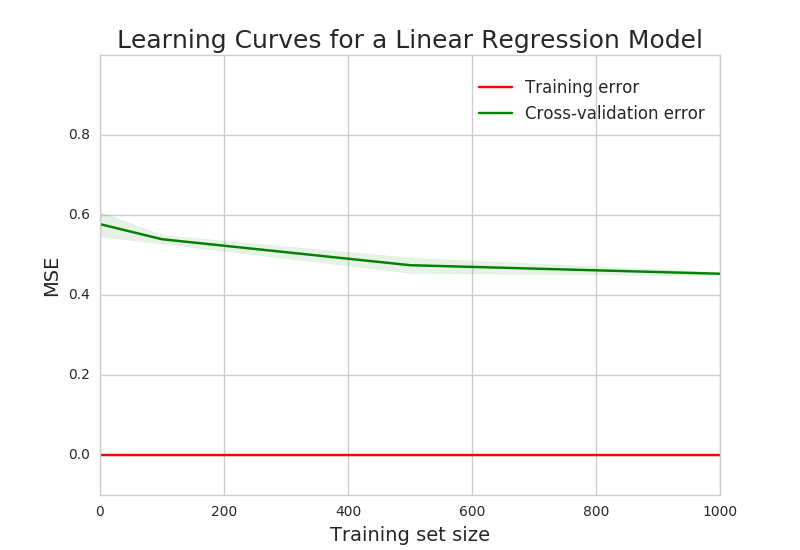

In [55]:
display(plot_learning_curve_DecisionTree())

### Model testing on the test data
And finally, wite your code to make a prediction and check the testing error.

In [57]:
test_predictions = final_model.predictAll(test_for_predict_RDD).map(lambda r: ((r[0], r[1]), r[2]))
test_rates_and_preds = rating_data.map(lambda r: ((int(r[0]), int(r[1])), float(r[2]))).join(test_predictions)
test_results_RDD = test_rates_and_preds.map(lambda r: (r[1][0], r[1][1]))   

In [58]:
arr_test = np.reshape(np.array(test_results_RDD.collect()), (-1, 2))
arr_test.shape

Out[ 58 ]: (19309, 2)

In [59]:
df_test =  pd.DataFrame(arr_test, columns = ["rating", "predicted_rating"])
display(df_test.head(10))

rating,predicted_rating
4.0,2.9532235753959615
2.5,3.037620144122963
4.0,3.8986114144264166
4.0,2.0306762545073545
5.0,4.137035396773973
4.5,3.2806776770809685
3.0,4.093161688218746
1.0,2.059390263515828
0.5,1.9121788127710215
4.5,3.798574952585053


In [60]:
test_error = math.sqrt(test_rates_and_preds.map(lambda r: (r[1][0] - r[1][1])**2).mean())
print(test_error)

0.8912383388610611

In [61]:
print ('To obtain test error we utilized the final ALS model which was trained previously. \n\nRMSE is {:.4f}'.format(test_error))

To obtain test error we utilized the final ALS model which was trained previously. 

RMSE is 0.8912

### Key Observations:
- RMSE of test data is at 0.8912, close to the least validation RMSE we obtained with the best model. **Model performed well.**
- In this case, RMSE is used as one metric for model evaluation. We could experiment with other metrics such as F1 score, accuracy, etc.
- This project was initialized with a small movie rating dataset. Errors and learning curve would look different compared to that of the complete dataset.
- In the linear regression model, we see validation error is slightly lower than training error while training set size increases. Generally speaking, training error will almost always underestimate your validation error. However it is possible for the validation error to be less than the training:
  - Training set had many 'hard' cases to learn.
  - Validation set had mostly 'easy' cases to predict.
  - That is why it is important that you really evaluate your model training methodology. If you don't split your data for training properly your results will lead to confusing, if not simply incorrect.
- Think of model evaluation in four different categories:
  - Underfitting – Validation and training error high
  - Overfitting – Validation error is high, training error low
  - **Good fit – Validation error low, slightly higher than the training error**
  - Unknown fit - Validation error low, training error 'high'
  
  
  
#### Model trained with the small dataset using Linear Regression Estmator is somewhere between a good fit and a "unknown fit"
  - Training score (red line) increases and plateau
    - Indicates high bias scenario 
  - Cross-validation score (green line) stagnating almost throughout
    - Unable to learn from data
  - Low MSE (low errors)
    - Should tweak model (**suggestion**: perhaps reduce model complexity)

#### Model trained with the small dataset using Decision Tree Regression estmator is overfitting
  - Training error (red line) is at its minimum regardless of training examples
    - Shows severe overfitting
  - Cross-validation score (green line) decreases over time
  - Huge gap between cross-validation score and training score 
    - Indicates high variance scenario
  - **Suggestions:** 
    - Reduce complexity of the model or gather more data (use the complete dataset)

### References of ALS

- Building a Movie Recommendation Service: https://www.codementor.io/jadianes/building-a-recommender-with-apache-spark-python-example-app-part1-du1083qbw
- MLlib - Collaborative Filtering: https://spark.apache.org/docs/1.1.0/mllib-collaborative-filtering.html
- Collaborative Filtering - RDD-based API: https://spark.apache.org/docs/latest/mllib-collaborative-filtering.html
- Evaluation Metrics - RDD-based API: https://spark.apache.org/docs/2.2.0/mllib-evaluation-metrics.html
- ML - ALS: https://towardsdatascience.com/prototyping-a-recommender-system-step-by-step-part-2-alternating-least-square-als-matrix-4a76c58714a1

### References of Learning Curve

- Learning Curve: https://www.ritchieng.com/machinelearning-learning-curve/
- Tutorial: Learning Curves: https://www.dataquest.io/blog/learning-curves-machine-learning/